In [48]:
import os
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import ImageGrid

import abnumber

In [49]:
DATA_PATH = "../lag21/results"
FIGURES_PATH = "figures"
TEMPS_TO_PLOT = [300, 336, 421]

if not os.path.isdir(FIGURES_PATH):
    os.makedirs(FIGURES_PATH, exist_ok=True)

## Domain boundaries

In [50]:
SEQUENCE = "AQVQLVESGGGLVQAGGSLRLSCAASGPTGAMAWFRQAPGMEREFVGGISGSETDTYYADFVKGRLTVDRDNVKNTVDLQMNSLKPEDTAVYYCAARRRVTLFTSRADYDFWGQGTQVTV"
OFFSET  = 4
resids = [OFFSET + i for i in range(len(SEQUENCE))]

In [51]:
def _get_boundary(seq, parent_seq, offset=0):
    start = offset + parent_seq.find(seq)
    stop = start + len(seq)
    return (start, stop)

Chain = abnumber.Chain(SEQUENCE, scheme="imgt")
domain_boundaries = {
    "fr1": _get_boundary(Chain.fr1_seq, SEQUENCE, offset=OFFSET),
    "fr2": _get_boundary(Chain.fr2_seq, SEQUENCE, offset=OFFSET),
    "fr3": _get_boundary(Chain.fr3_seq, SEQUENCE, offset=OFFSET),
    "fr4": _get_boundary(Chain.fr4_seq, SEQUENCE, offset=OFFSET),
    "cdr1": _get_boundary(Chain.cdr1_seq, SEQUENCE, offset=OFFSET),
    "cdr2": _get_boundary(Chain.cdr2_seq, SEQUENCE, offset=OFFSET),
    "cdr3": _get_boundary(Chain.cdr3_seq, SEQUENCE, offset=OFFSET),
}

for k,v in domain_boundaries.items():
    print(k, v)

fr1 (5, 30)
fr2 (35, 52)
fr3 (60, 98)
fr4 (115, 124)
cdr1 (30, 35)
cdr2 (52, 60)
cdr3 (98, 115)


## RMSD per residue plots

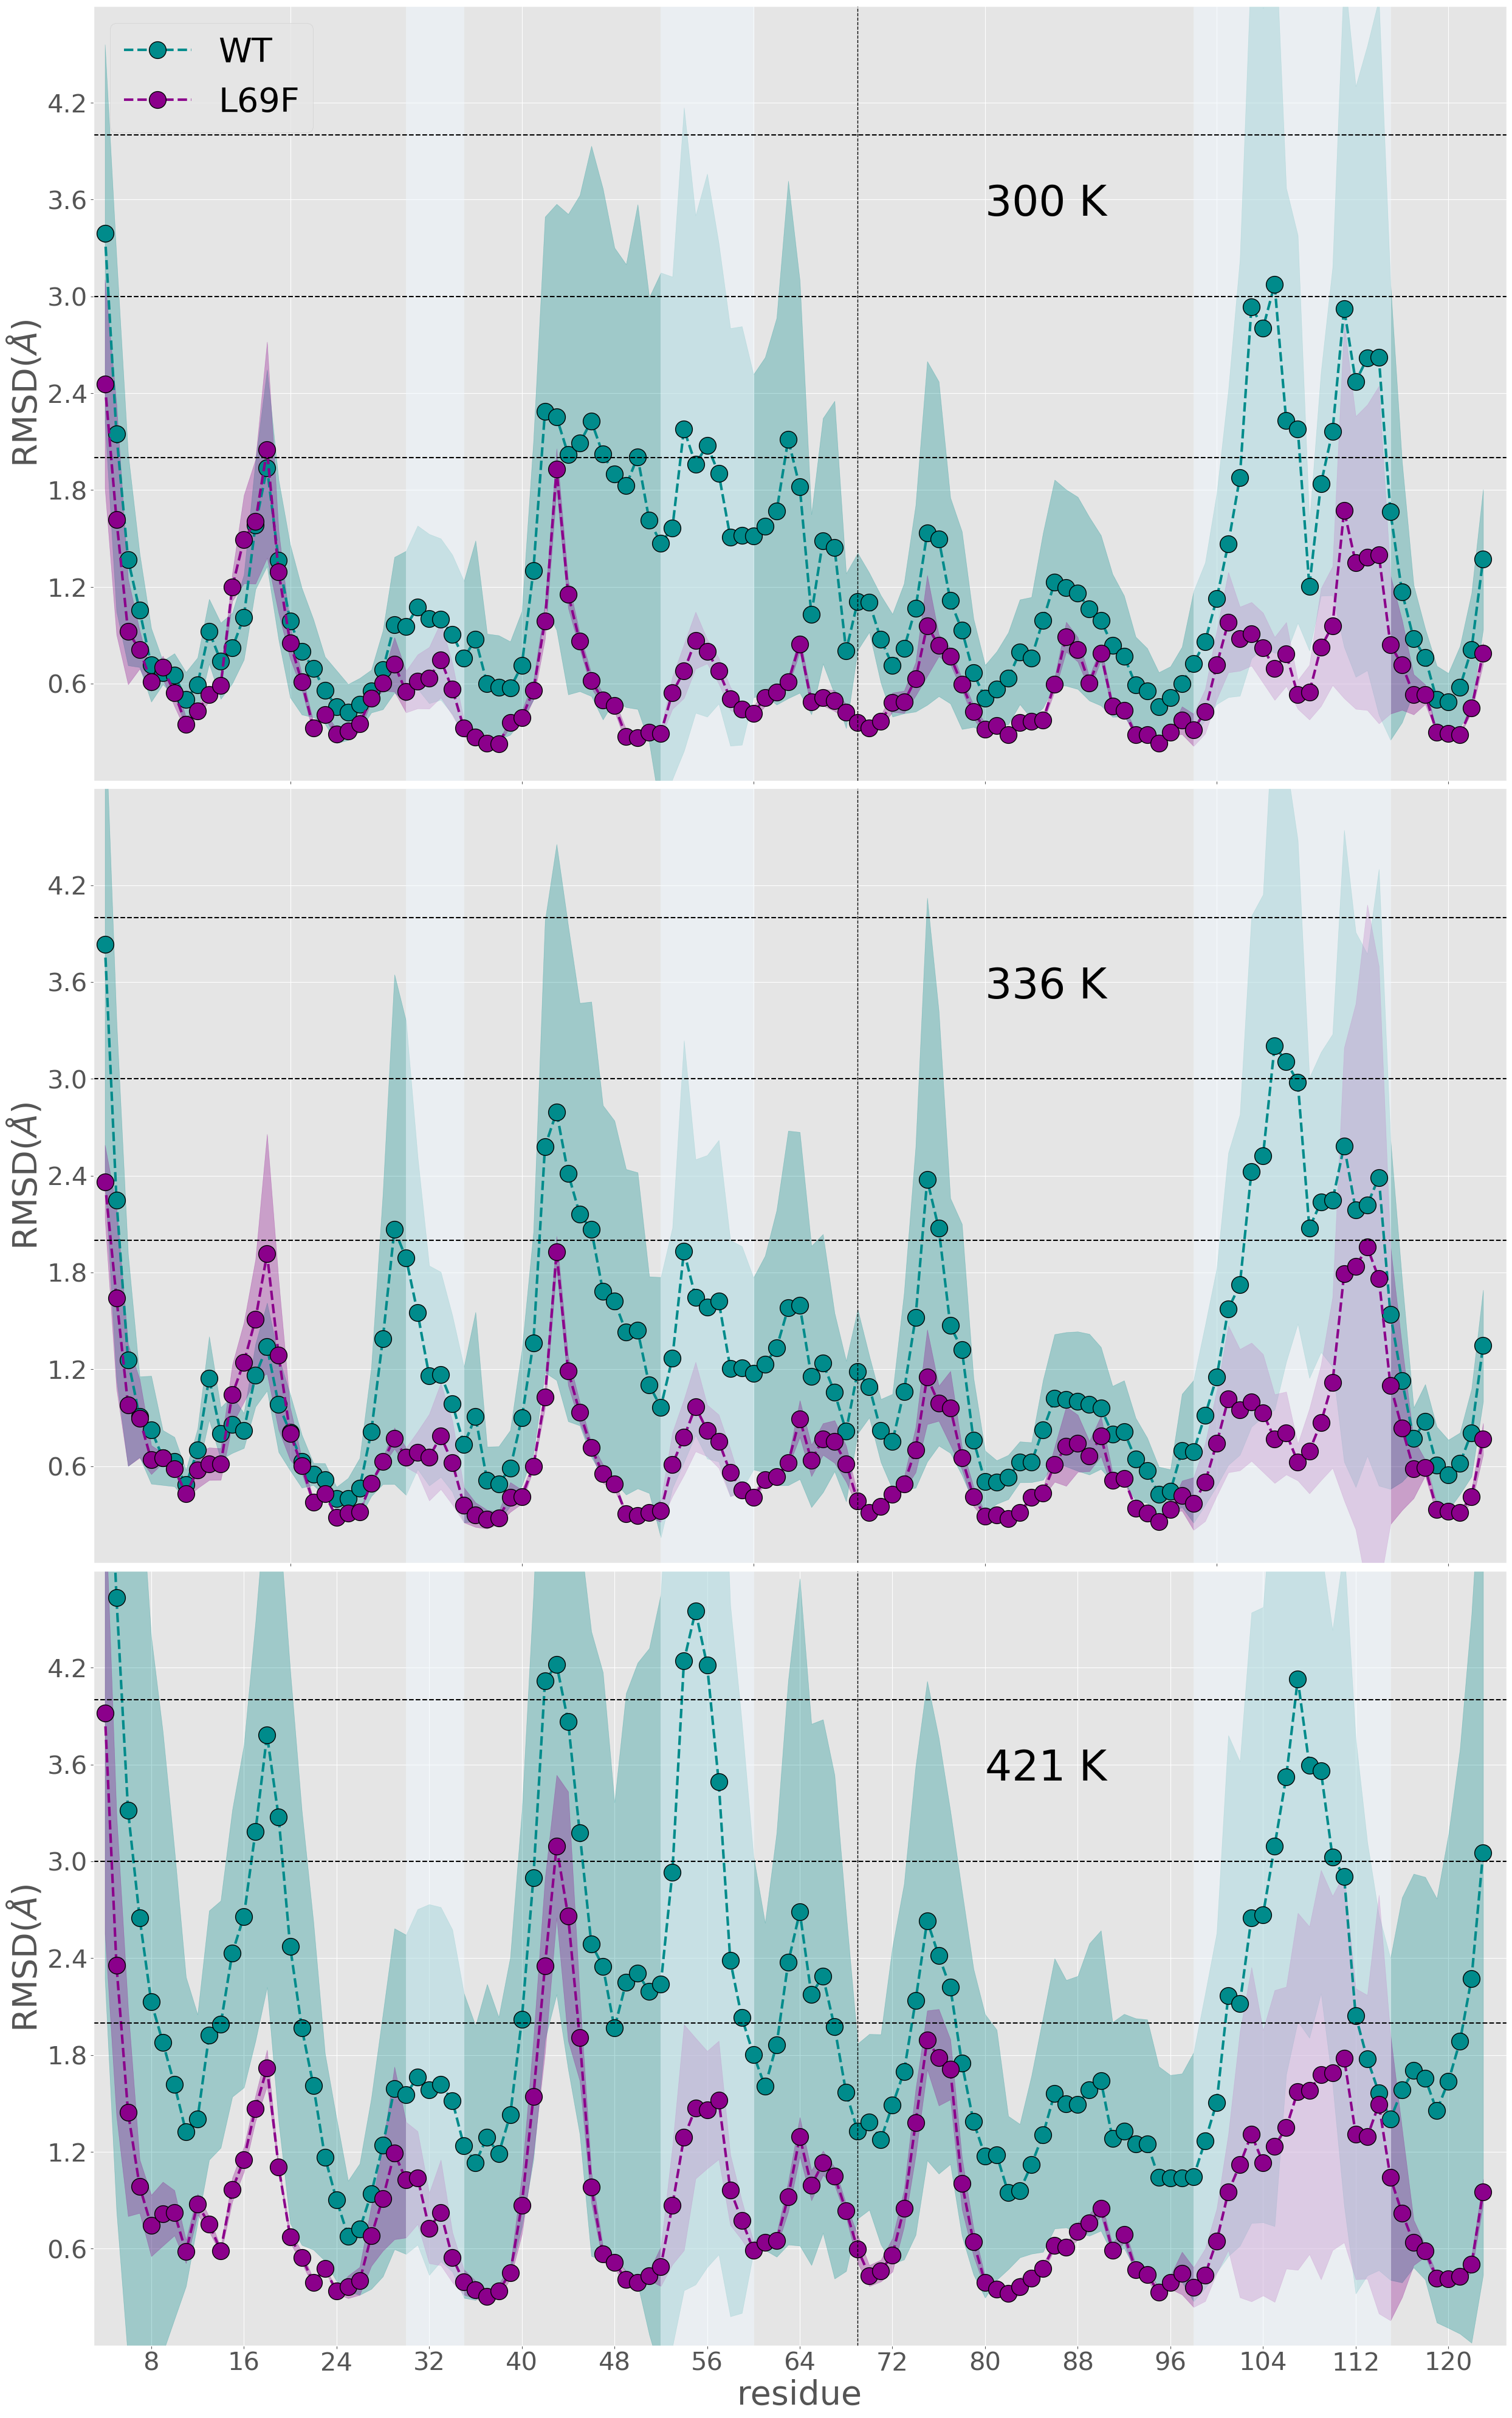

In [52]:
resids = [4+i for i in range(len(SEQUENCE))]

plt.style.use("ggplot")
fig = plt.figure(figsize=(30, 50))
axs = []

df = pd.read_csv(os.path.join(DATA_PATH, "per_residue_rmsd.csv"))

for i, t in enumerate(TEMPS_TO_PLOT):
    ax = fig.add_subplot(len(TEMPS_TO_PLOT), 1, i+1)
    
    # wild type
    rmsds_wt_mean = df[f"wt_{t}K_mean"].values
    rmsds_wt_err = df[f"wt_{t}K_err"].values
    ax.plot(
        resids, rmsds_wt_mean,
        marker="o", ls="--", 
        color="darkcyan", markeredgecolor="black",
        lw=3, markersize=20, label=f"WT"
    )
    
    ax.fill_between(
        resids, rmsds_wt_mean-rmsds_wt_err, rmsds_wt_mean+rmsds_wt_err,
        color="darkcyan", alpha=0.3
    )
    
    # mutation
    rmsds_mut_mean = df[f"mut_{t}K_mean"].values
    rmsds_mut_err = df[f"mut_{t}K_err"].values
    ax.plot(
        resids, rmsds_mut_mean, 
        marker="o", ls="--",
        color="darkmagenta", markeredgecolor="black",
        lw=3, markersize=20, label=f"L69F"
    )
    
    ax.fill_between(
        resids, rmsds_mut_mean-rmsds_mut_err, rmsds_mut_mean+rmsds_mut_err,
        color="darkmagenta", alpha=0.3
    )
    
    # domain boundaries
    for k,v in domain_boundaries.items():
        if "cdr" in k:
            ax.axvspan(*v, color="aliceblue", alpha=0.5)
    ax.axvline(69, ls="--", lw=1, color="black")
    
    # axis limits
    ax.set_xlim([3, 5+len(resids)])
    ax.set_ylim([0.0, 4.8])
    
    # annotations
    if i == 0:
        ax.legend(loc=2, fontsize=40)
    ax.annotate(f"{t} K", xy=(80, 3.5), fontsize=50)
    
    # design
    ax.set_ylabel("RMSD" + r"$(\AA)$", fontsize=40)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=8, prune="both"))
    
    if i < len(TEMPS_TO_PLOT)-1:
        ax.tick_params(axis="y", labelsize=30)
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else:
        ax.xaxis.set_major_locator(MaxNLocator(nbins=20, prune="both"))
        ax.tick_params(axis="both", labelsize=30)
        ax.set_xlabel("residue", fontsize=40)
    
    ax.axhline(2.0, ls="--", color="black", lw=1.5)
    ax.axhline(3.0, ls="--", color="black", lw=1.5)
    ax.axhline(4.0, ls="--", color="black", lw=1.5)
    axs.append(ax)

plt.subplots_adjust(hspace=0.01)
plt.show()

fig.savefig(os.path.join(FIGURES_PATH, "panelA.svg"), dpi=200, bbox_inches="tight")

## Correlation maps

300 0.04838417265316476 0.01740305915134789
336 0.05968040287956844 0.01589863015273377
421 0.11261684065332273 0.027874174509494098


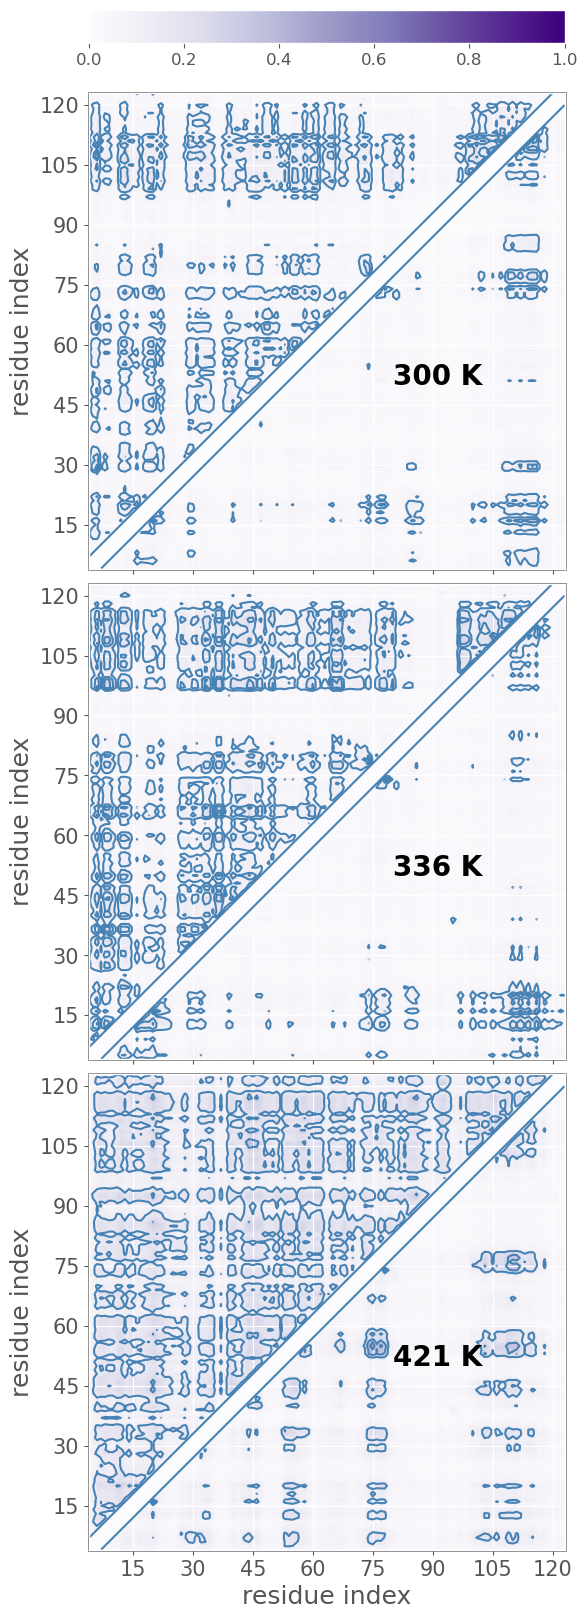

In [54]:
def _make_combined_map(temp):
    fn_wt = os.path.join(DATA_PATH, "correlation_maps", f"wt_{temp}K.npz")
    X_wt_data = np.load(fn_wt)
    X_wt, X_wt_err = X_wt_data["C"], X_wt_data["Cerr"]
    
    fn_mut = os.path.join(DATA_PATH, "correlation_maps", f"mut_{temp}K.npz")
    X_mut_data = np.load(fn_mut)
    X_mut, X_mut_err = X_mut_data["C"], X_mut_data["Cerr"]
    
    nres = X_wt.shape[1]
    X = np.zeros([nres, nres])
    for i in range(nres):
        for j in range(nres):
            if abs(i-j) <= 3: continue
            elif i < j: X[i,j] = X_wt[i,j]
            else: X[i,j] = X_mut[i,j]
    
    avg_wt_err = np.mean(X_wt_err)
    avg_mut_err = np.mean(X_mut_err)
    
    return np.transpose(X), avg_wt_err, avg_mut_err


fig = plt.figure(figsize=(30, 20))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(3,1),
    axes_pad=0.15,
    share_all=True,
    cbar_location="top",
    cbar_mode="single",
    cbar_size="7%",
    cbar_pad=0.5
)

for i, ax in enumerate(grid):
    # plot as smoothened image
    X, wt_err, mut_err = _make_combined_map(TEMPS_TO_PLOT[i])
    im = ax.imshow(
       X, extent=[resids[0], resids[-1]]*2, 
       vmin=0, vmax=1,
       origin="lower", cmap="Purples", interpolation="gaussian"
    )
    
    # highlight the contours
    imc = ax.contour(
        resids, resids, X,
        extent=[resids[0], resids[-1]]*2,
        vmin=0, vmax=1,
        levels=4, origin="lower",
        colors="steelblue"
    )
    
    # design
    ax.set_ylabel("residue index", fontsize=18)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=8, prune="both"))
    
    if i < len(TEMPS_TO_PLOT) - 1:
        ax.tick_params(axis="y", labelsize=15)
        ax.set_xlabel("")
    else:
        ax.xaxis.set_major_locator(MaxNLocator(nbins=8, prune="both"))
        ax.tick_params(axis="both", labelsize=15)
        ax.set_xlabel("residue index", fontsize=18)
    
    # border
    ax.patch.set_edgecolor("dimgrey")  
    ax.patch.set_linewidth(2)
    
    # annotation
    ax.annotate(f"{TEMPS_TO_PLOT[i]} K", xy=(80, 50), fontsize=20, weight="bold")
    
    print(TEMPS_TO_PLOT[i], wt_err, mut_err)
    
# colorbar
cb = ax.cax.colorbar(im)
ax.cax.tick_params(labelsize=12)

plt.subplots_adjust(hspace=0.2)
plt.show()

fig.savefig(os.path.join(FIGURES_PATH, "panelC.svg"), dpi=200, bbox_inches="tight")